In [87]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import pymc3 as pm

%matplotlib inline

In [88]:
def gen_data(seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    t = 1000
    nbreak = 3
    tbreak = np.sort(np.random.randint(100, 900, nbreak-1))
    theta = np.random.exponential(25, size=nbreak)
    theta_t = np.zeros(t)
    theta_t[:tbreak[0]] = theta[0]
    theta_t[tbreak[0]:tbreak[1]] = theta[1]
    theta_t[tbreak[1]:] = theta[2]
    y = np.random.poisson(theta_t)

    _, ax = plt.subplots(1, 1, figsize=(15, 3))
    ax.plot(range(t), y)
    ax.plot(theta_t);
    return theta_t, y

In [89]:
# based on
# https://gist.github.com/junpenglao/f7098c8e0d6eadc61b3e1bc8525dd90d

import theano.tensor as tt
from pymc3.distributions.transforms import ElemwiseTransform, Transform

class Ordered(ElemwiseTransform):
    name = "ordered"

    def backward(self, y):
        out = tt.zeros(y.shape)
        out = tt.inc_subtensor(out[0], y[0])
        out = tt.inc_subtensor(out[1:], tt.exp(y[1:]))
        return tt.cumsum(out)

    def forward(self, x):
        out = tt.zeros(x.shape)
        out = tt.inc_subtensor(out[0], x[0])
        out = tt.inc_subtensor(out[1:], tt.log(x[1:] - x[:-1]))
        return out

    def forward_val(self, x, point=None):
        x, = draw_values([x], point=point)
        return self.forward(x)

    def jacobian_det(self, y):
        return tt.sum(y[1:])

ordered = Ordered()


class Composed(Transform):
    def __init__(self, transform1, transform2):
        self._transform1 = transform1
        self._transform2 = transform2
        self.name = '_'.join([transform1.name, transform2.name])

    def forward(self, x):
        return self._transform2.forward(self._transform1.forward(x))

    def forward_val(self, x, point=None):
        return self.forward(x)

    def backward(self, y):
        return self._transform1.backward(self._transform2.backward(y))

    def jacobian_det(self, y):
        y2 = self._transform2.backward(y)
        det1 = self._transform1.jacobian_det(y2)
        det2 = self._transform2.jacobian_det(y)
        return det1 + det2

In [90]:
def plot_fit(y, theta_t, trace, log=False, mu=None):
    _, ax = plt.subplots(1, 1, figsize=(15, 3))
    if log:
        y = np.log(y)
        theta_t = np.log(theta_t)
        fit = np.log(trace['theta'].T)
    else:
        fit = trace['theta'].T
    ax.plot(range(t), y)
    ax.plot(fit, alpha=.01, color='k')
    ax.plot(theta_t);
    if mu is not None:
        plt.axhline(mu)
    
def logistic(k, l=1, t=np.arange(-1, 1, .01)):
    return l/(1+np.exp(-k*t))

def plot_smoothness(trace, l=1, n_samples=50, t=np.arange(-.5, .5, .01)):
    out = np.empty((n_samples, t.shape[0]))
    trace_df = pm.trace_to_dataframe(trace)
    
    for i in np.arange(n_samples):
        random_row = np.random.randint(low=0, high=trace_df.shape[0])
        out[i,:] = logistic(trace_df.iloc[random_row]['smoothness'], l=l, t=t)
        plt.plot(t, out[i,:])
    
    plt.plot(t, out.mean(0))

### Dataset 1

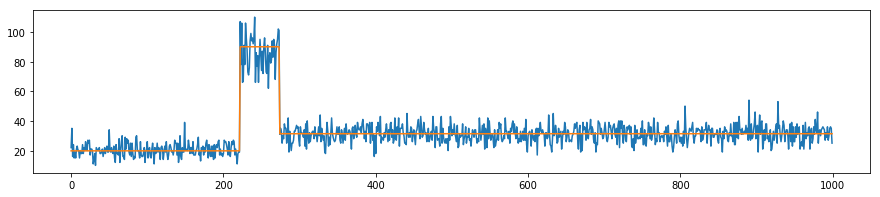

In [91]:
# seed = 4 is a tricky dataset, let's look at that one. Seed=1 works easily, for example
theta_t, y = gen_data(4)

## Model 1: "inverse smoothness" k fixed to 500

In [108]:
mu = np.log(y.mean())
sd = np.log(y.std())
t_ = np.linspace(0., 1., t)
print(mu)
print(sd)

with pm.Model() as m1:
    lambda0 = pm.Normal('lambda0', mu, sd=sd)
    lambdad = pm.Normal('lambdad', mu=0, sd=sd, shape=2)
    k = 500
    trafo = Composed(pm.distributions.transforms.LogOdds(), Ordered())
    b = pm.Beta('b', 1., 1., shape=2, transform=trafo,
                    testval=[0.3, 0.5])
    theta_ = pm.Deterministic('theta', tt.exp(lambda0 + \
                                              lambdad[0]/(1+tt.exp(-k*(t_-b[0]))) + \
                                              (lambdad[1]-lambdad[0])/(1+tt.exp(-k*(t_-b[0])))))
    obs = pm.Poisson('obs', theta_, observed=y)
    
    trace = pm.sample(step=pm.Metropolis(), draws=int(1e6), n_init=int(1e6))

3.456505937421036
2.6855830466639263


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [b_logodds]
>Metropolis: [lambdad]
>Metropolis: [lambda0]
Sampling 4 chains: 100%|██████████| 4002000/4002000 [29:54<00:00, 2230.59draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [135]:
?pm.traceplot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e94cc6160>,
      dtype=object)

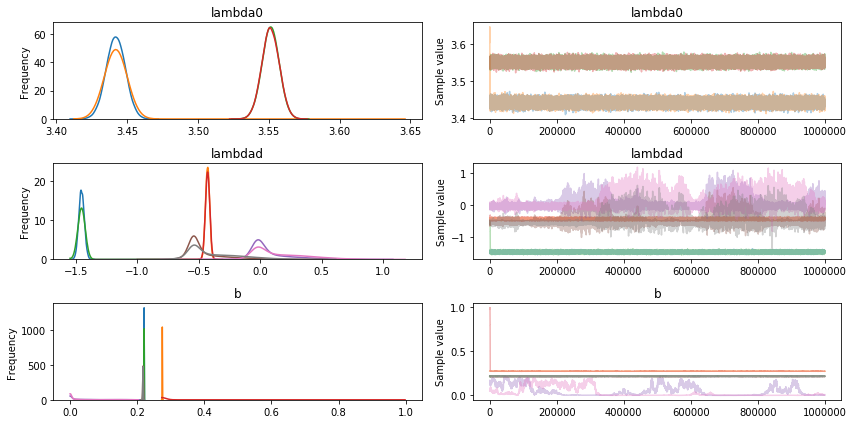

In [109]:
pm.traceplot(trace, varnames=['lambda0', 'lambdad', 'b'])

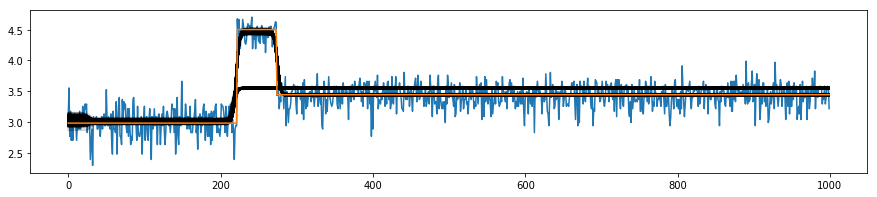

In [107]:
plot_fit(y, theta_t, trace, log=True)

In [117]:
logp = [m1.logp(trace[i]) for i in [10, 20]]

In [133]:
logp = m1.logp 
lnp = np.array([logp(trace.point(i, chain=c)) for c in trace.chains for i in [-1]])

In [134]:
lnp

array([-3216.63087734, -3216.88460602, -4671.09268681, -4666.23908745])

In [ ]:
# final LL of the first two chains are *much* better

In [171]:
trace.point(-1, chain=1)

{'lambda0': 3.44808356718045,
 'lambdad': array([-1.41590906, -0.42512869]),
 'b_logodds_ordered__': array([-1.26126712, -1.22316742]),
 'b': array([0.22075584, 0.27548474]),
 'theta': array([20.55193047, 20.55193047, 20.55193047, 20.55193047, 20.55193047,
        20.55193047, 20.55193047, 20.55193047, 20.55193047, 20.55193047,
        20.55193047, 20.55193047, 20.55193047, 20.55193047, 20.55193047,
        20.55193047, 20.55193047, 20.55193047, 20.55193047, 20.55193047,
        20.55193047, 20.55193047, 20.55193047, 20.55193047, 20.55193047,
        20.55193047, 20.55193047, 20.55193047, 20.55193047, 20.55193047,
        20.55193047, 20.55193047, 20.55193047, 20.55193047, 20.55193047,
        20.55193047, 20.55193047, 20.55193047, 20.55193047, 20.55193047,
        20.55193047, 20.55193047, 20.55193047, 20.55193047, 20.55193047,
        20.55193047, 20.55193047, 20.55193047, 20.55193047, 20.55193047,
        20.55193047, 20.55193047, 20.55193047, 20.55193047, 20.55193047,
        20.55

In [148]:
trace.__dict__

{'_straces': {0: <pymc3.backends.ndarray.NDArray at 0x7f2e61252908>,
  1: <pymc3.backends.ndarray.NDArray at 0x7f2e950fa940>,
  2: <pymc3.backends.ndarray.NDArray at 0x7f2e60f910f0>,
  3: <pymc3.backends.ndarray.NDArray at 0x7f2e94ff2dd8>},
 '_report': <pymc3.backends.report.SamplerReport at 0x7f2e94ef62b0>}

In [ ]:
## Some chains seem fine, some fail to pick up the cut-offs

## Model 2: "inverse smoothness" k estimated

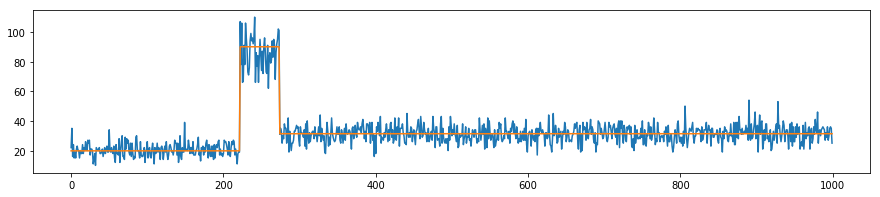

In [60]:
theta_t, y = gen_data(4)

In [100]:
mu = np.log(y.mean())
sd = np.log(y.std())
t = 1000
t_ = np.linspace(0., 1., t)
print(mu)
print(sd)

with pm.Model() as m3:
    # draw cuts
    trafo = Composed(pm.distributions.transforms.LogOdds(), Ordered())
    b = pm.Beta('b', 1., 1., shape=2, transform=trafo, testval=[0.3, 0.5])
    
    # determine EVs
    lambda0 = pm.Normal('lambda0', mu, sd, shape=1)
    lambdas = pm.Normal('lambdas', 0, sd, shape=2)
    
    # inverse smoothness: prefer a non-smooth cut-off
    k = 500 #pm.TruncatedNormal('smoothness', 500, 5, lower=0)
    
    theta_ = pm.Deterministic('theta', 
                              tt.exp(lambda0 + \
                                     lambdas[0]/(1+tt.exp(-k*(t_-b[0]))) + \
                                     (lambdas[1]-lambdas[0])/(1+tt.exp(-k*(t_-b[1])))))  # intercept section 3
    obs = pm.Poisson('obs', theta_, observed=y)
    
    trace = pm.sample(step=pm.Metropolis())

3.456505937421036
2.6855830466639263


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambdas]
>Metropolis: [lambda0]
>Metropolis: [b_logodds]
Sampling 4 chains:   0%|          | 0/4000 [00:00<?, ?draws/s]


RuntimeError: Chain 2 failed.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ec39a74e0>,
      dtype=object)

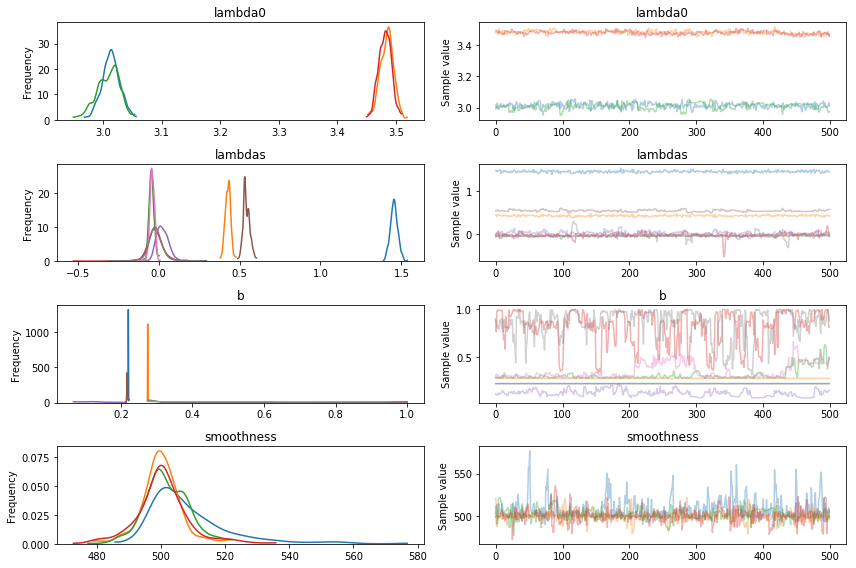

In [67]:
pm.traceplot(trace, varnames=['lambda0', 'lambdas', 'b', 'smoothness'])

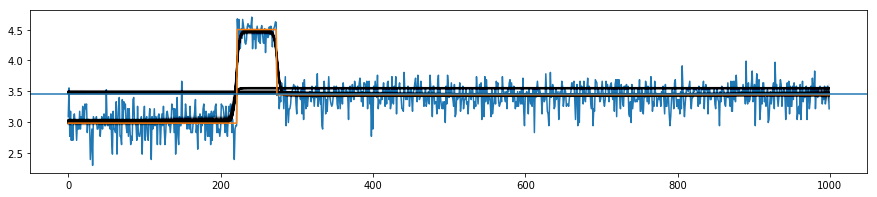

In [68]:
plot_fit(y, theta_t, trace, log=True)#, mu=mu)
plt.axhline(mu)

## Model 3

In [ ]:
mu = np.log(y.mean())
sd = np.log(y.std())
sd2 = (y/y.mean()).std()
t = 1000
t_ = np.linspace(0., 1., t)
print(mu)
print(sd)

with pm.Model() as m3:
    # draw cuts
    trafo = Composed(pm.distributions.transforms.LogOdds(), Ordered())
    b = pm.Beta('b', 1., 1., shape=2, transform=trafo, testval=[0.3, 0.5])
    
    # determine EVs
    lambda0 = pm.Normal('lambda0', mu, sd, shape=1)
    lambdas = pm.Normal('lambdas', 1, 0.1, shape=2)
    
    # inverse smoothness: prefer a non-smooth cut-off
    k = pm.Laplace('smoothness', 500, 5)
    
    theta_ = pm.Deterministic('theta', 
                              tt.exp(lambda0 + \
                                     lambda0*lambdas[0]/(1+tt.exp(-k*(t_-b[0]))) + \
                                     lambda0*lambdas[1]/(1+tt.exp(-k*(t_-b[1])))))  # intercept section 3
    obs = pm.Poisson('obs', theta_, observed=y)
    
    trace = pm.sample(draws=500)#init='advi+adapt_diag')

3.456505937421036
2.6855830466639263


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [smoothness, lambdas, lambda0, b_logodds]
Sampling 4 chains:  84%|████████▍ | 3355/4000 [00:55<04:37,  2.32draws/s] 

In [ ]:
pm.traceplot(trace, varnames=['lambda0', 'lambdas', 'b', 'smoothness'])

In [ ]:
plot_fit(y, theta_t, trace, log=True)#, mu=mu)
plt.axhline(mu)